<a href="https://colab.research.google.com/github/a7lamx/Assignment/blob/main/Facial_Emotion_Recognition_final_MobilNet_vs_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **importing library**

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import imagenet_utils

from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_PATH = "/content/drive/MyDrive/FER13 Cleaned Dataset/"

In [ ]:
import os
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

disgust has 380 number of images
Happy has 6834 number of images
fear has 2535 number of images
Neutral has 4313 number of images
Angry has 2832 number of images

total images are 16894


In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16514

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Happy images to numpy arrays
loaded all fear images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Angry images to numpy arrays


((16514, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [ ]:
label_to_text

{0: 'Happy', 1: 'fear', 2: 'Neutral', 3: 'Angry'}

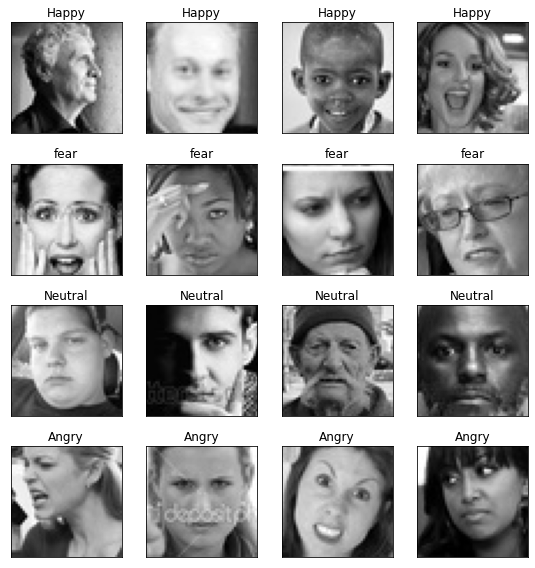

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16514, 4)

In [ ]:
img_arr = img_arr / 255.

# **Split the data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14862, 48, 48, 3), (1652, 48, 48, 3), (14862, 4), (1652, 4))

In [ ]:
del img_arr
del img_label

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
print(input_shape)

(224, 224, 3)


# **MobileNet**

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)
#fine-tuning process: start by getting all of the layers up to 14 to last layer ,we keep all layers and transfer into a new model and not include the last 14 layers
x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)#mobilnet is a functional model
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)#create output layer, to this ouput layer pass all of the previous layerrs that we have stored in x up ot the 14 last layer 

model = Model(inputs=mobile_net.input, outputs=out) #create model by using x and out(inputs: from the origonal mobilnet model and output = out) so the model is all the mobilnet layer layers up to 14 to last layer + out layer

17235968/17225924 [==============================] - 1s 0us/step


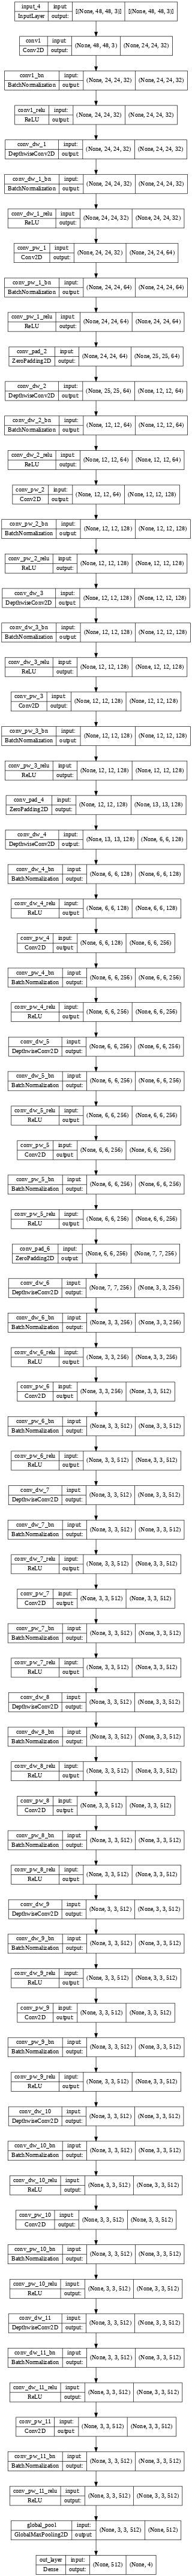

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:#Freeze some layer 
    layer.trainable = False

In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

# ***Training ***
 represent the tarin and valid accuracy with batch_size = 25 epochs = 40

In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


594/594 [==============================] - 20s 29ms/step - loss: 1.2888 - accuracy: 0.5018 - val_loss: 1.2576 - val_accuracy: 0.4891 - lr: 0.0100
Epoch 2/40
594/594 [==============================] - 18s 30ms/step - loss: 1.0208 - accuracy: 0.5922 - val_loss: 0.8990 - val_accuracy: 0.6531 - lr: 0.0100
Epoch 3/40
594/594 [==============================] - 19s 32ms/step - loss: 0.9162 - accuracy: 0.6355 - val_loss: 0.9485 - val_accuracy: 0.6065 - lr: 0.0100
Epoch 4/40
594/594 [==============================] - 16s 27ms/step - loss: 0.8745 - accuracy: 0.6480 - val_loss: 0.9385 - val_accuracy: 0.6519 - lr: 0.0100
Epoch 5/40
594/594 [==============================] - 16s 26ms/step - loss: 0.8479 - accuracy: 0.6680 - val_loss: 0.9426 - val_accuracy: 0.5987 - lr: 0.0100
Epoch 6/40
594/594 [==============================] - 16s 27ms/step - loss: 0.8269 - accuracy: 0.6705 - val_loss: 0.8141 - val_accuracy: 0.6743 - lr: 0.0100
Epoch 7/40
594/594 [==============================] - 16s 27ms/step -

In [ ]:
model_json = model.to_json()
with open("model_mobelnet.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model_moblenet.h5")

# **Plot the result of the training (LOSS AND ACCURACY)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

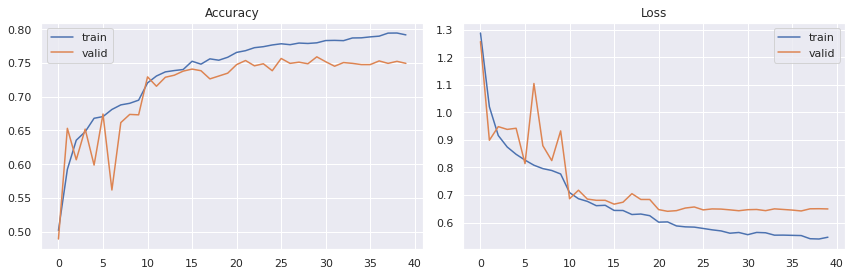

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()


In [ ]:
label_to_text

{0: 'Happy', 1: 'fear', 2: 'Neutral', 3: 'Angry'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 3, 'Happy': 0, 'Neutral': 2, 'fear': 1}

In [ ]:
!pip install  scikit_plot

# **Testing the model and the reselt**

test accuracy: 74.9395 %


              precision    recall  f1-score   support

           0       0.92      0.85      0.88       684
           1       0.67      0.53      0.59       254
           2       0.64      0.82      0.72       431
           3       0.63      0.60      0.61       283

    accuracy                           0.75      1652
   macro avg       0.71      0.70      0.70      1652
weighted avg       0.76      0.75      0.75      1652



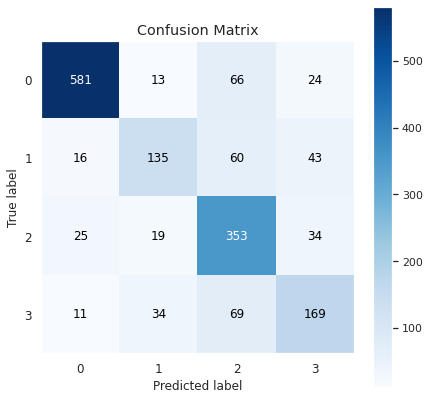

In [ ]:
import scikitplot
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

# **The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to happy.**

# **Predict on fear and anger images**

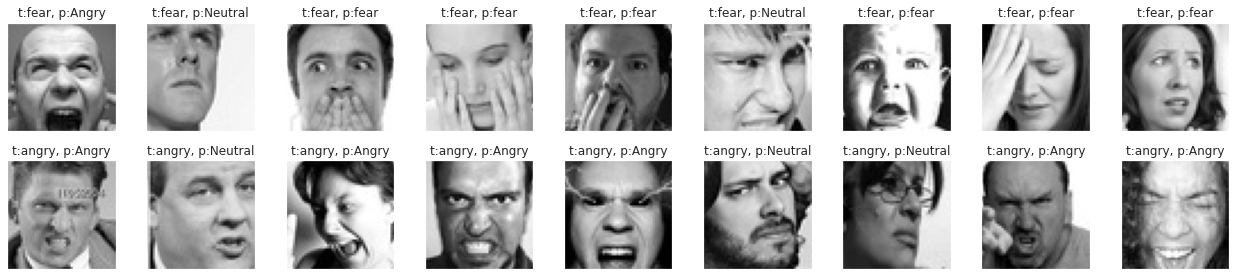

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

# **One of the reason for such low accuracy is the data quality. Below I have shown all the miss-classified images. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class**

# (**Plot the missed classified in all emotions**)

In [ ]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f" pr:{pred}")

total 103 miss labels out of 684 for emotion Happy


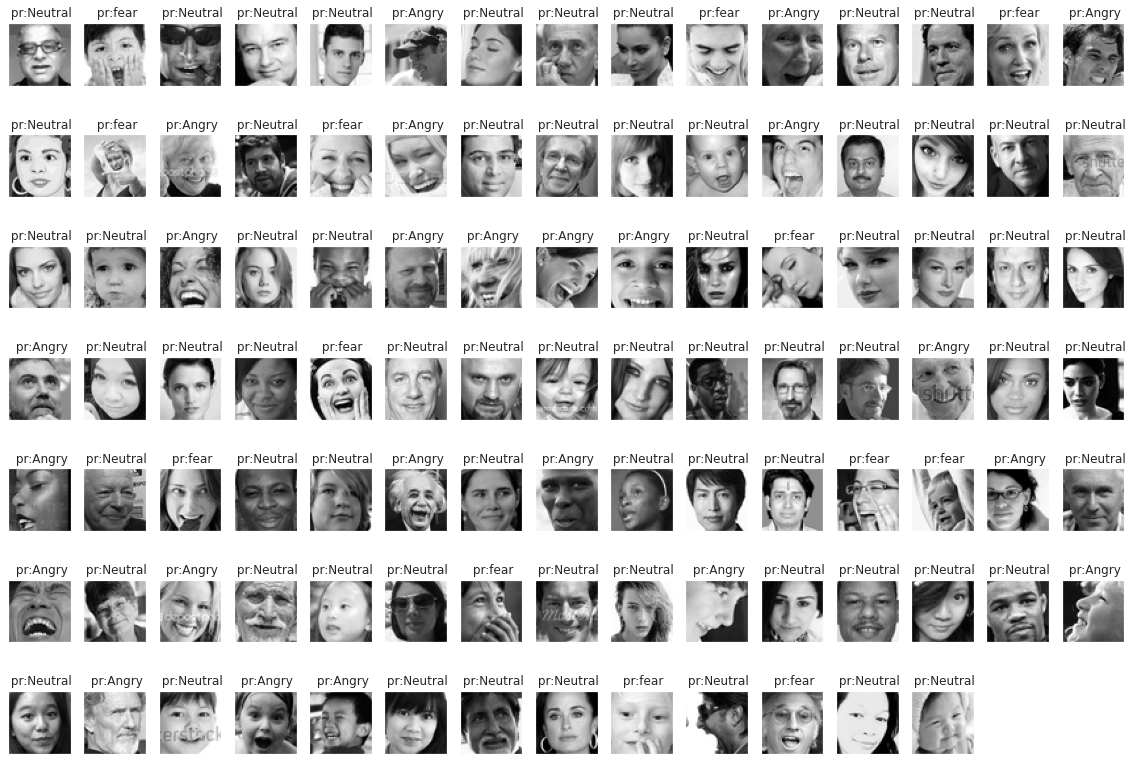

In [ ]:
plot_miss_classified(emotion="Happy")

# **As we see most of these are classified as Neutral the reason for that is that most of the Neutral mouths are closed as we see in Neutral faces ,also when the mouth is open it consedert as fear or angery**

total 119 miss labels out of 254 for emotion fear


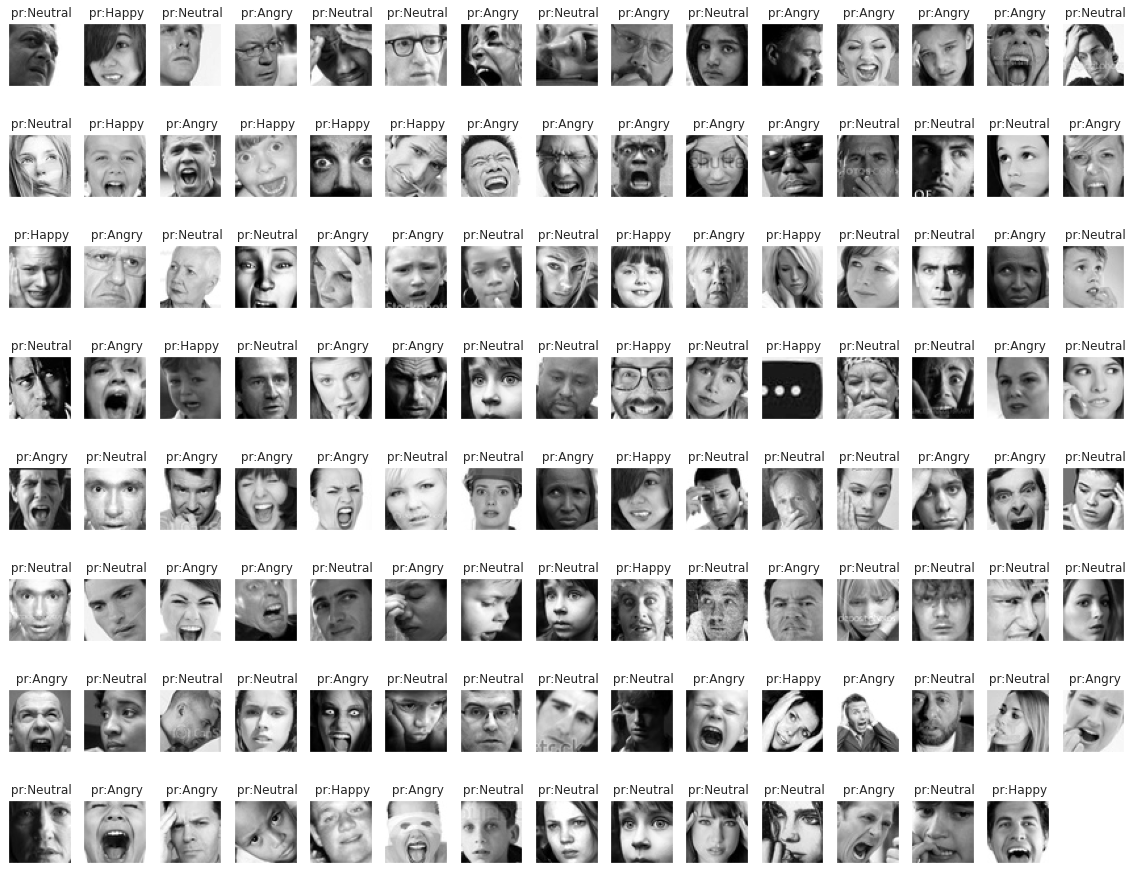

In [ ]:
plot_miss_classified(emotion="fear")

total 114 miss labels out of 283 for emotion Angry


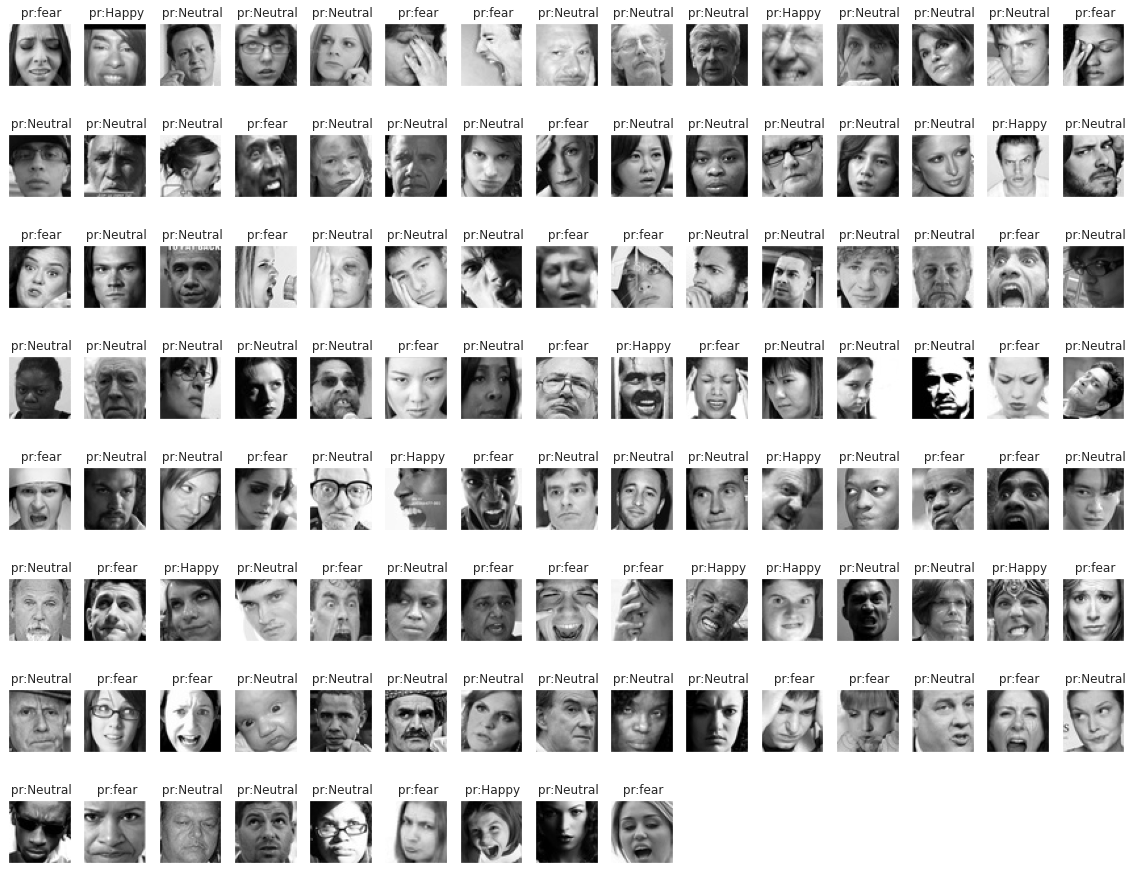

In [ ]:
plot_miss_classified(emotion="Angry")

total 78 miss labels out of 431 for emotion Neutral


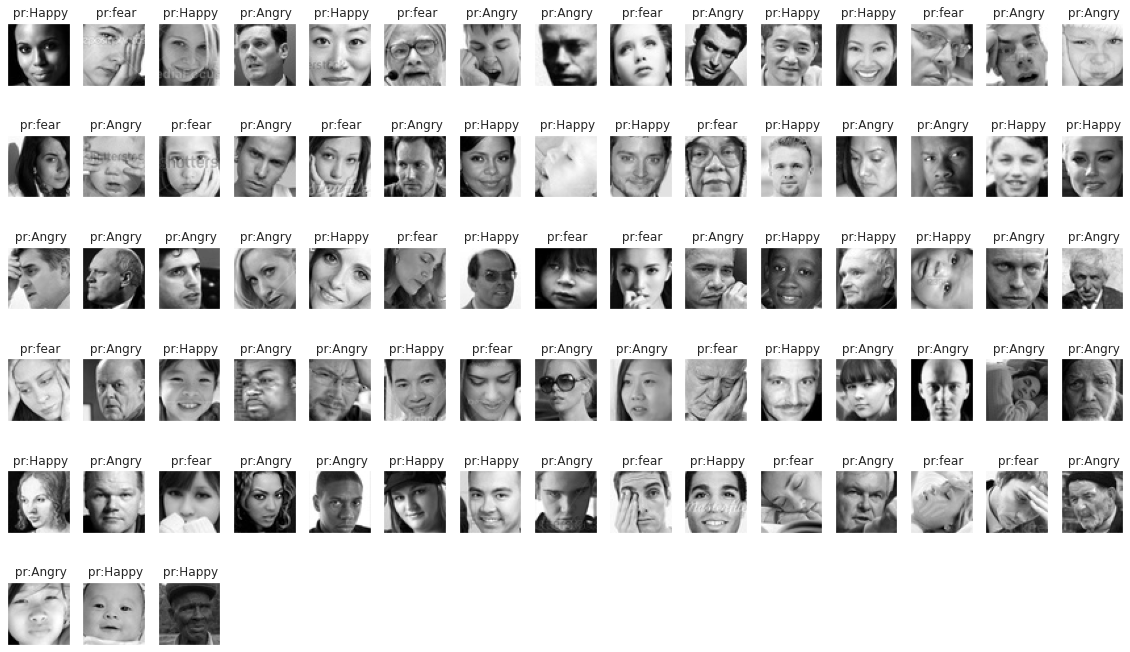

In [ ]:
plot_miss_classified(emotion="Neutral")

In [ ]:
!pip install scikit_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
VGG16 = VGG16(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = VGG16.layers[-6].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

modelRe = Model(inputs=VGG16.input, outputs=out)

In [ ]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
for layer in modelRe.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

# ***Training ***
represent the tarin and valid accuracy with batch_size = 25 epochs = 40

In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

modelRe.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = modelRe.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    callbacks=callbacks,
    epochs=epochs,
    
    use_multiprocessing=True
)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


594/594 [==============================] - 17s 27ms/step - loss: 3.6565 - accuracy: 0.4158 - val_loss: 2.7166 - val_accuracy: 0.5127 - lr: 0.0100
Epoch 2/40
594/594 [==============================] - 14s 24ms/step - loss: 3.0876 - accuracy: 0.4479 - val_loss: 2.9647 - val_accuracy: 0.4927 - lr: 0.0100
Epoch 3/40
594/594 [==============================] - 17s 28ms/step - loss: 3.0899 - accuracy: 0.4474 - val_loss: 2.4721 - val_accuracy: 0.5218 - lr: 0.0100
Epoch 4/40
594/594 [==============================] - 18s 29ms/step - loss: 3.0604 - accuracy: 0.4576 - val_loss: 3.2946 - val_accuracy: 0.5430 - lr: 0.0100
Epoch 5/40
594/594 [==============================] - 16s 27ms/step - loss: 3.6367 - accuracy: 0.4477 - val_loss: 2.4659 - val_accuracy: 0.5521 - lr: 0.0100
Epoch 6/40
594/594 [==============================] - 14s 24ms/step - loss: 3.1496 - accuracy: 0.4546 - val_loss: 5.7847 - val_accuracy: 0.4722 - lr: 0.0100
Epoch 7/40
594/594 [==============================] - 18s 30ms/step -

# **Plot the result of the training (LOSS AND ACCURACY)**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

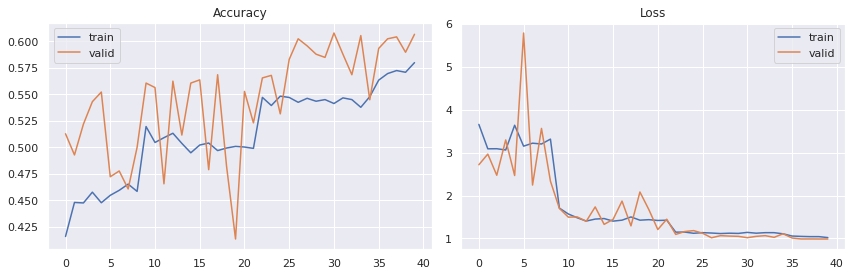

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_ResNet50.png')
pyplot.show()


In [ ]:
label_to_text

{0: 'Happy', 1: 'fear', 2: 'Neutral', 3: 'Angry'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 3, 'Happy': 0, 'Neutral': 2, 'fear': 1}

# **Testing the model and the reselt**

test accuracy: 60.6538 %


              precision    recall  f1-score   support

           0       0.71      0.80      0.75       684
           1       0.64      0.27      0.38       254
           2       0.55      0.58      0.56       431
           3       0.42      0.48      0.45       283

    accuracy                           0.61      1652
   macro avg       0.58      0.53      0.54      1652
weighted avg       0.61      0.61      0.59      1652



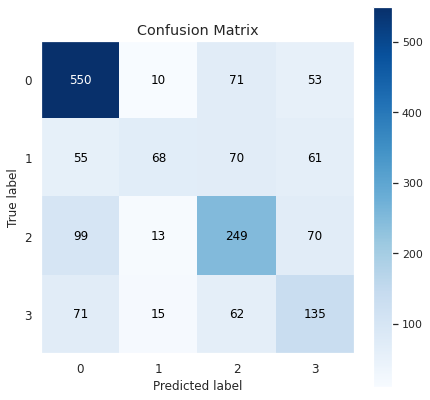

In [ ]:
import scikitplot
yhat_test = np.argmax(modelRe.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_ResNet50.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

# **Predict on fear and anger images**

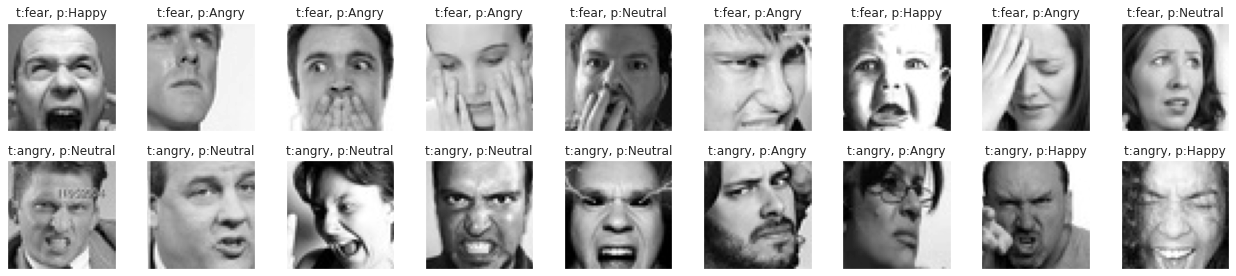

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

# **Plot the missed classified in all emotions**

In [ ]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f" pr:{pred}")

total 134 miss labels out of 684 for emotion Happy


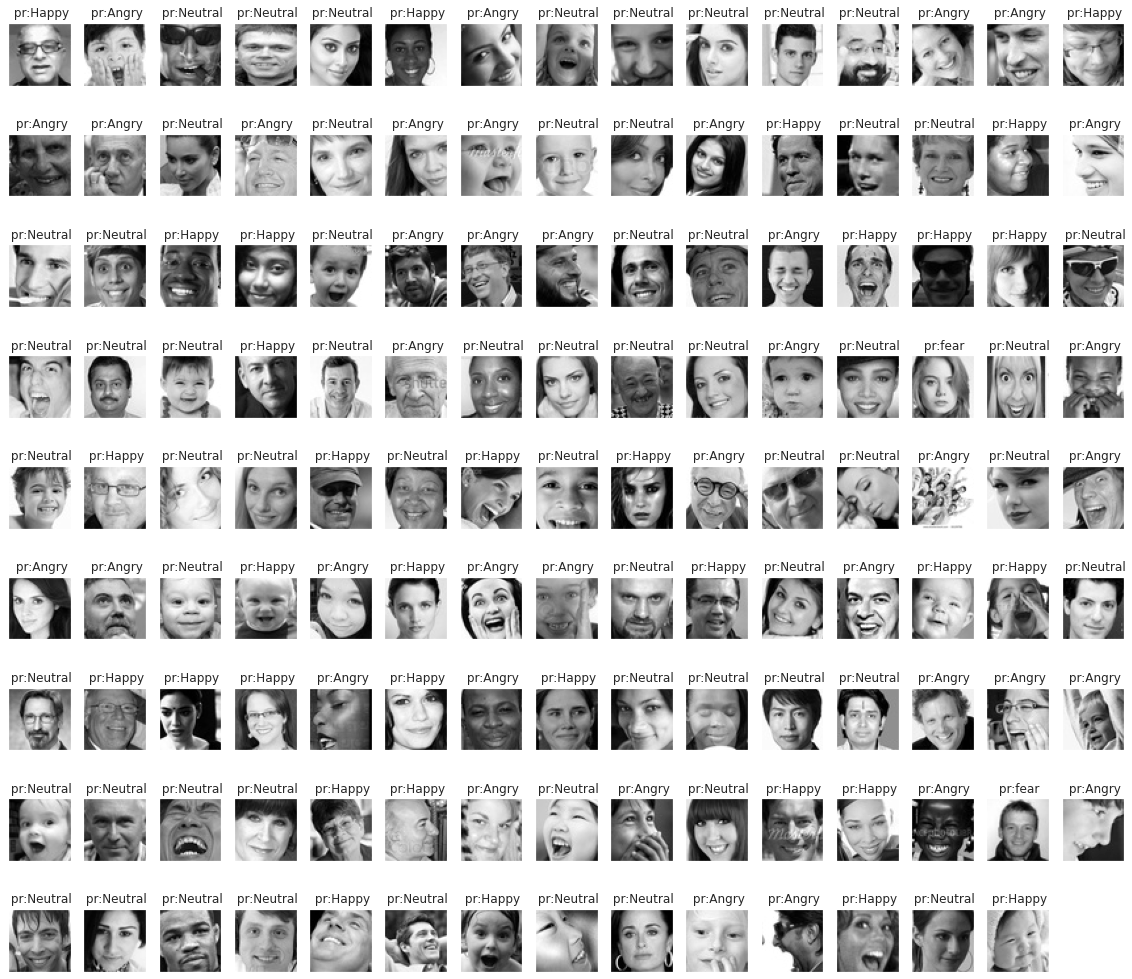

In [ ]:
plot_miss_classified(emotion="Happy")

total 186 miss labels out of 254 for emotion fear


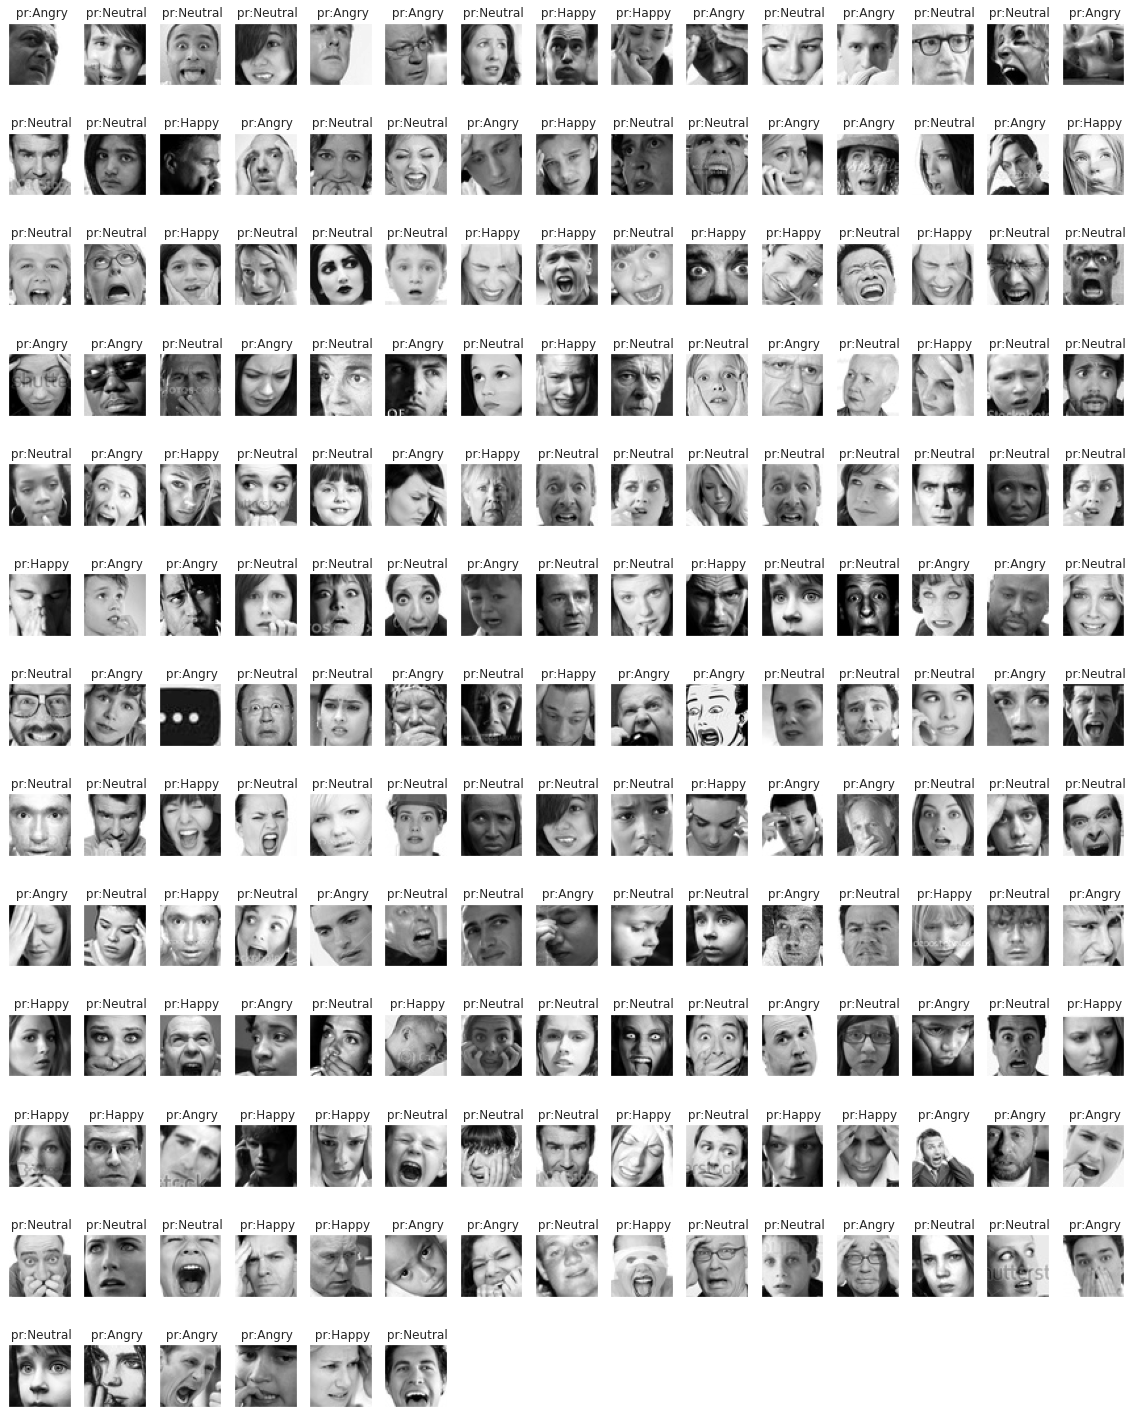

In [ ]:
plot_miss_classified(emotion="fear")

total 148 miss labels out of 283 for emotion Angry


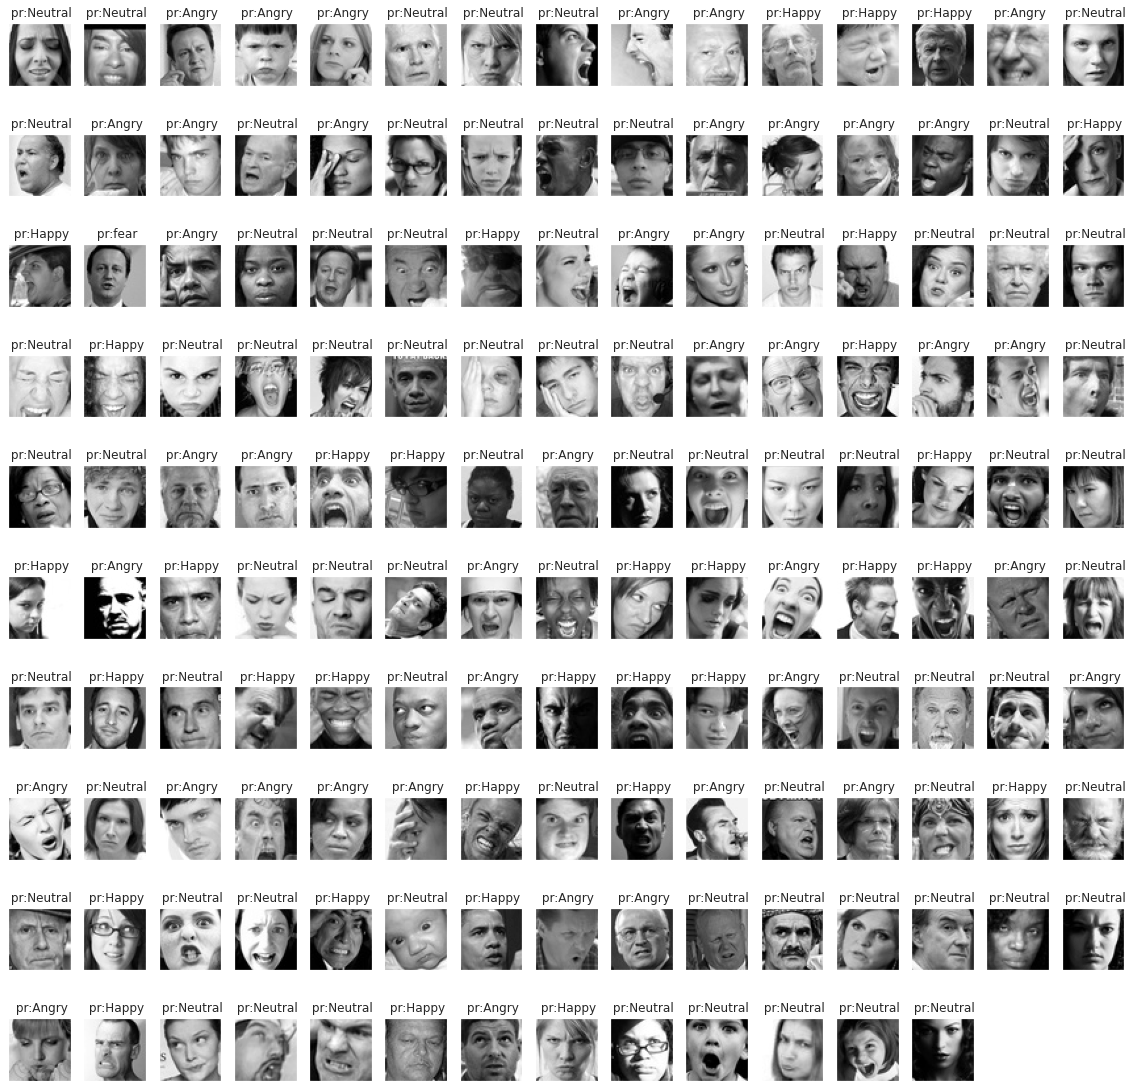

In [ ]:
plot_miss_classified(emotion="Angry")

total 182 miss labels out of 431 for emotion Neutral


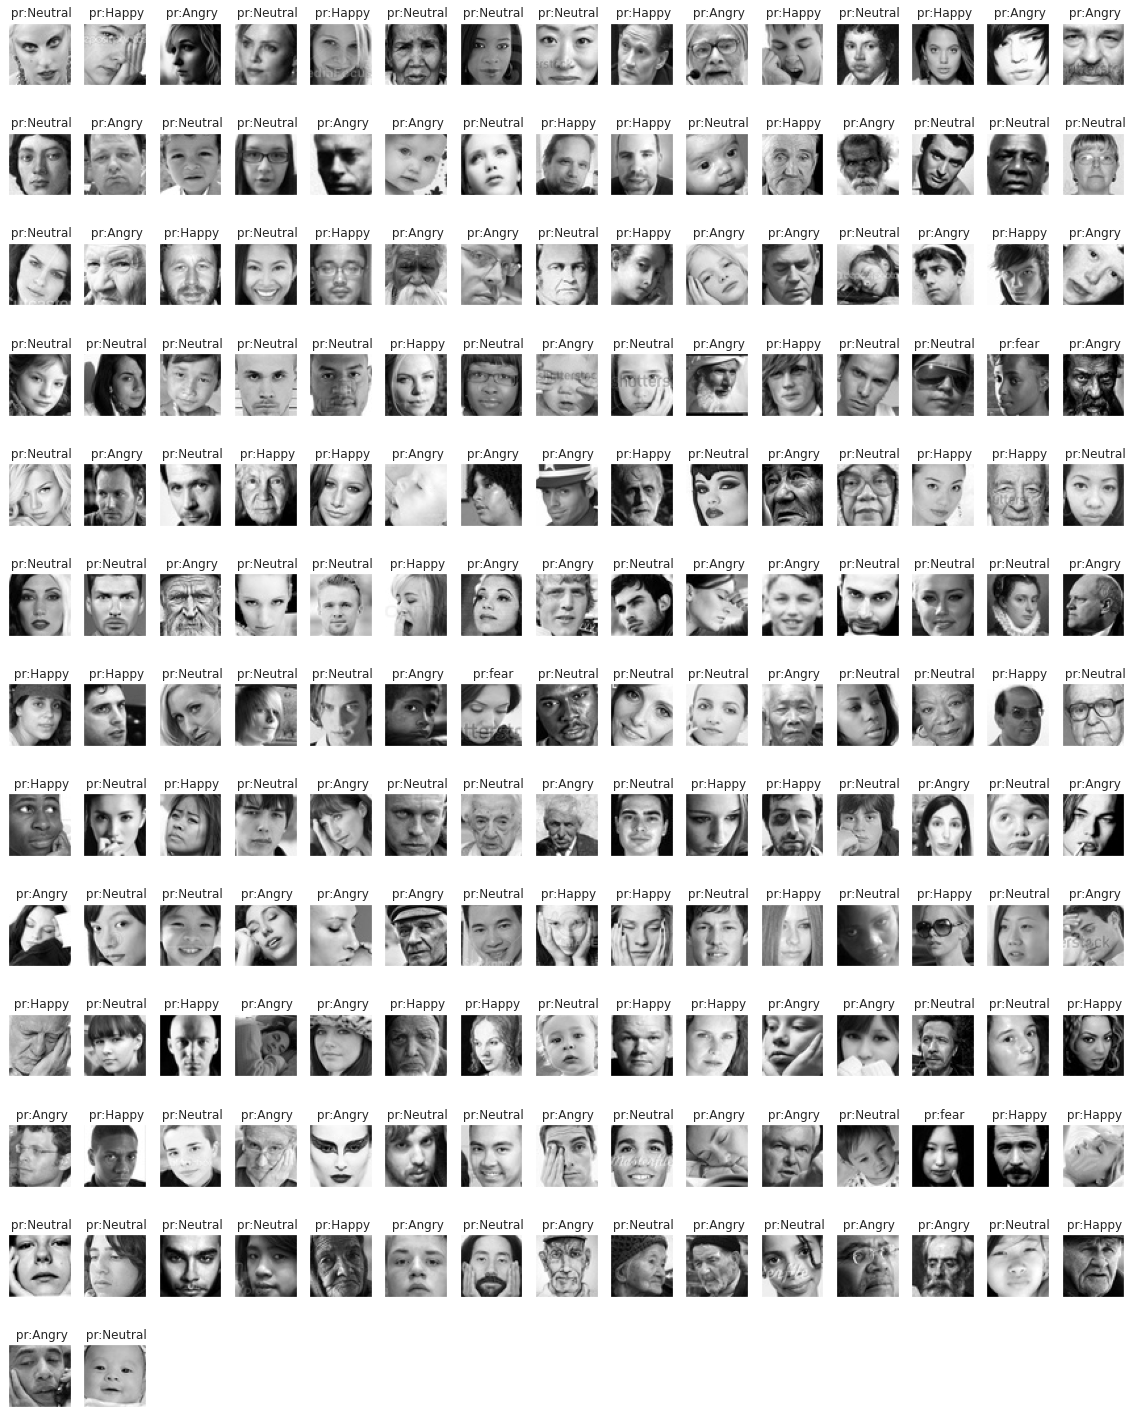

In [ ]:
plot_miss_classified(emotion="Neutral")